In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import json
import copy
import warnings
warnings.filterwarnings('ignore') # allow warning to be seen once (action='once') or set to ('ignore')

# Starbucks Customer Analysis

## Portfolio Data
Information about the promotional offers that are possible to receive, and basic information about each one including the promotional type, duration of the promotion, reward, and how the promotion was distributed to customers.

In [23]:
portfolio_df = pd.read_csv('archive/portfolio.csv')
portfolio_df.drop('Unnamed: 0', inplace = True, axis = 1)

In [24]:
portfolio_df['channels_web'] = portfolio_df.channels.str.contains('web')
portfolio_df['channels_email'] = portfolio_df.channels.str.contains('email')
portfolio_df['channels_mobile'] = portfolio_df.channels.str.contains('mobile')
portfolio_df['channels_social'] = portfolio_df.channels.str.contains('social')
portfolio_df = portfolio_df[['id','reward', 'difficulty', 'duration', 'offer_type','channels',
       'channels_web', 'channels_email', 'channels_mobile', 'channels_social']]
portfolio_df.channels = portfolio_df.channels.str.replace(r'[^a-z\,]','')
portfolio_df.channels.replace('web,email,mobile,social','wems', inplace = True)
portfolio_df.channels.replace('web,email,mobile','wem', inplace = True)
portfolio_df.channels.replace('email,mobile,social','ems', inplace = True)
portfolio_df.channels.replace('web,email','we', inplace = True)

# simplify the 'id' feature to be promo_chronological number
# portfolio_df.id.replace(

In [25]:
portfolio_df.head(10)

,id,reward,difficulty,duration,offer_type,channels,channels_web,channels_email,channels_mobile,channels_social
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,ems,False,True,True,True
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,wems,True,True,True,True
2,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,wem,True,True,True,False
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,wem,True,True,True,False
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,we,True,True,False,False
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,wems,True,True,True,True
6,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,wems,True,True,True,True
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,ems,False,True,True,True
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,wems,True,True,True,True
9,2906b810c7d4411798c6938adc9daaa5,2,10,7,discount,wem,True,True,True,False


In [26]:
# Thinking a bayesian model would work well for this data

## Profile Data

Dimensional data about each person, including their age, salary, and gender. There is one unique customer for each record. <br> 
**(17000 records)** 

,id,member_date,member_year,member_month,gender,age,income,known_prof
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,2017,2,NaN,118,NaN,False
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2017,7,F,55,112000.0,True


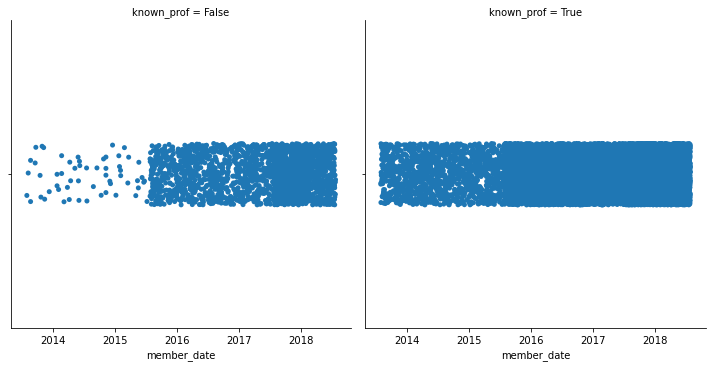

In [27]:
profile_df = pd.read_csv('archive/profile.csv')
profile_df.drop('Unnamed: 0', inplace = True, axis = 1)
profile_df.rename(columns = {'became_member_on': 'member_date'}, inplace = True)
profile_df['member_date'] = pd.to_datetime(profile_df['member_date'], format = '%Y%m%d')
profile_df['member_year'] = pd.DatetimeIndex(profile_df['member_date']).year
profile_df['member_month'] = pd.DatetimeIndex(profile_df['member_date']).month
profile_df = profile_df[['id','member_date','member_year','member_month','gender','age','income']]
# Seperate known_df and unknown_df
unknowns_df = profile_df[profile_df['gender'].isna()]
knowns_df = profile_df[profile_df['gender'].notna()]
# Create boolean for known and unknown customer profiles
profile_df['known_prof'] = profile_df['gender'].notna()
# plot
sns.catplot(data = profile_df
            , x = 'member_date'
            , col = 'known_prof'
            )
profile_df.head(2)

- There are 2175 unknown profiles that have 
    - an age of 118 years old 
    - no gender
    - no income value 
- We will seperate the records into knowns and unknown profiles. <br> 
- Idea here is that we will go from: <br>
1) known profiles<br>
2) to order transaction history<br>
3) group those with unsupervised model <br>
4) then see if we can use the model to fill in the unknown data<br>

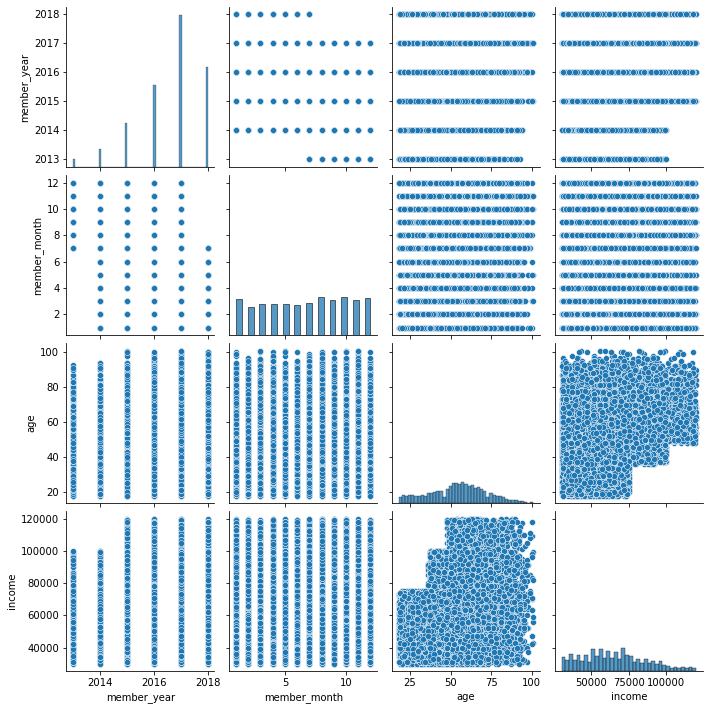

In [28]:
sns.pairplot(data = knowns_df)

Next three cells look into the earliest member in the data

In [29]:
print('Earliest Member Date:',profile_df.member_date.min())
profile_df[(profile_df.member_year == 2013)&(profile_df.member_month == 7)]

Earliest Member Date: 2013-07-29 00:00:00


,id,member_date,member_year,member_month,gender,age,income,known_prof
569,dbb4766b7dd94ca2b83a855312a3ebe9,2013-07-30,2013,7,M,36,74000.0,True
1200,5ffdab087e674149a89324a732b4f993,2013-07-30,2013,7,M,52,65000.0,True
7796,d25f38519a89455499c9e49e67ae1511,2013-07-30,2013,7,F,58,55000.0,True
8948,77388a70eaf14433b4efc5d01fa947bf,2013-07-29,2013,7,M,64,69000.0,True
10933,7b42b5bbe237406aaf2748a09050f745,2013-07-31,2013,7,F,67,58000.0,True


In [30]:
print('Looking at the member date of a transaction with a max time value (714)')
profile_df[profile_df.id == 'c02b10e8752c4d8e9b73f918558531f7']

Looking at the member date of a transaction with a max time value (714)


,id,member_date,member_year,member_month,gender,age,income,known_prof
16994,c02b10e8752c4d8e9b73f918558531f7,2015-12-11,2015,12,NaN,118,NaN,False


## Transcript Data
Records show the different steps of promotional offers that a customer received. The different values of receiving a promotion are receiving, viewing, and completing. You also see the different transactions that a person made in the time since they became a customer. With all records, you see the time that they interacted with Starbucks and the amount that it is worth. <br> 
**(306534 records)**

In [31]:
transcript_df = pd.read_csv('archive/transcript.csv')
transcript_df.drop('Unnamed: 0', inplace = True, axis = 1)
transcript_df['value'] = transcript_df['value'].apply(eval) # use eval for str to dict
value_split_df = transcript_df['value'].apply(pd.Series)    # split dict into seperate cols
transcript_df = transcript_df.join(value_split_df, how = 'left') # join into main transcript_df
transcript_df['offer_id'] = transcript_df['offer_id'].fillna(transcript_df['offer id']) # create 1 offer_id col
transcript_df.drop(['offer id','value'], inplace = True, axis = 1) # drop cols that are dups
col_order = ['person','offer_id','event','amount','reward','time'] # set col order
transcript_df = transcript_df[col_order] # reorder cols
transcript_df.rename(columns = {'reward':'reward_rcvd'}, inplace = True)
transcript_df.head(1).append(transcript_df.tail(1))
print('Records in transcript_df:',len(transcript_df))

Records in transcript_df: 306534


**Note:** What I am doing is looking to see if the member_date can be linked to the time zero of the customer in the transaction data. I first assumed that each customer would have have began with an 'offer received', which seems to be the majority of the starting scenarios for customers, but that is not necesarily the case for everyone. <br>
**Distribution of starting scenario (@time=0)**
 - offer received - (12650) <br>
 - offer viewed - (0)<br>
 - transaction - (111) <br>
 - offer completed - (0)<br>
This totals up to **12761** customers with a time=0 event out of 17000 customers. <br> 
This leaves **4239** that don't have an initial event at zero. Basically 25% of customers. Interesting.

In [32]:
customer_list = transcript_df.person.unique()
t0_time = transcript_df[((transcript_df['event'] == 'offer received')|
                   (transcript_df['event'] == 'offer viewed')|
                   (transcript_df['event'] == 'transaction')|
                   (transcript_df['event'] == 'offer completed'))
                    &(transcript_df['time'] == 0)].drop_duplicates(subset = ['person'])

print('Total Unique Customers:',len(customer_list)) # total unique customers in the transaction data
print('Unique Customers with a zero start time and known event:', len(t0_time))
print('Unique Customers with a non-zero start time:',len(customer_list)-len(t0_time))
print('Percentage of customers with a zero start time:',round(12761/17000,2))
print('-------------')
print(t0_time.event.value_counts())
print('-------------')

Total Unique Customers: 17000
Unique Customers with a zero start time and known event: 12761
Unique Customers with a non-zero start time: 4239
Percentage of customers with a zero start time: 0.75
-------------
offer received    12650
transaction         111
Name: event, dtype: int64
-------------


 - **'t'** : is the list of id's with times that are greater than 0
     - In the list of times there is a pattern of adding 6 from [6 : 408].
     - From 408 it is [24, 12, 42, 12, 60, 12]

In [33]:
# For loop to find first recorded non-zero event time of customers in transcript_df
t = []
for x in transcript_df['person'].unique():
    df_1 = transcript_df[transcript_df['person'] == x]
    if df_1.time.min()>0:
        t.append([x,df_1.time.min()])
time_first_df = pd.DataFrame(t, columns = ['person','first_time'])
transcript_df = pd.merge(transcript_df,time_first_df, how = 'left', on = 'person').fillna(0)

In [34]:
print(pd.DataFrame(t)[0].unique())

['32189735a963491082e35dd4c3221690' '203831402e2b49a8bf1fa35263f17165'
 '1e90d5a75b1d47e6ac495c37399705da' ... '912b9f623b9e4b4eb99b6dc919f09a93'
 '3045af4e98794a04a5542d3eac939b1f' 'da7a7c0dcfcb41a8acc7864a53cf60fb']


-------------
min: 0.0
max: 582.0
-------------
Unique times of offers received: [  0 168 336 408 504 576]
Notice spike at 168 (2nd offer received): 1537
-------------


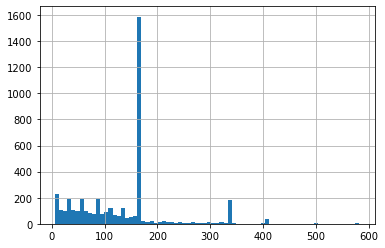

In [35]:
print('-------------')
print('min:',transcript_df.drop_duplicates(subset = ['person']).first_time.min())
print('max:',transcript_df.drop_duplicates(subset = ['person']).first_time.max())
print('-------------')
# take one customer record to see distribution of unique non-zero start times
unique_customers_df = transcript_df.drop_duplicates(subset = ['person'])
unique_customers_df[unique_customers_df['first_time']>0].first_time.hist(bins = 74)
print('Unique times of offers received:',transcript_df[transcript_df['event'] == 'offer received'].time.unique())
print('Notice spike at 168 (2nd offer received):',unique_customers_df[unique_customers_df['first_time']==168].first_time.count())
print('-------------')

array([<AxesSubplot:title={'center':'offer completed'}>,
       <AxesSubplot:title={'center':'offer received'}>,
       <AxesSubplot:title={'center':'offer viewed'}>,
       <AxesSubplot:title={'center':'transaction'}>], dtype=object)

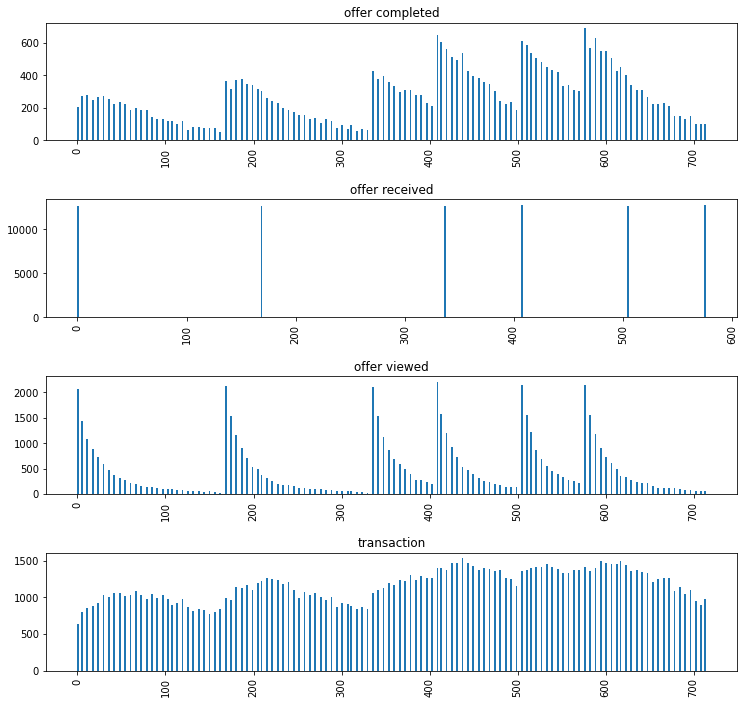

In [36]:
transcript_df[['event','time']].hist(by = 'event', layout = (4,1),bins = 350, figsize = (12,12))

Total offer_id count: 12650
mean: 1265.0


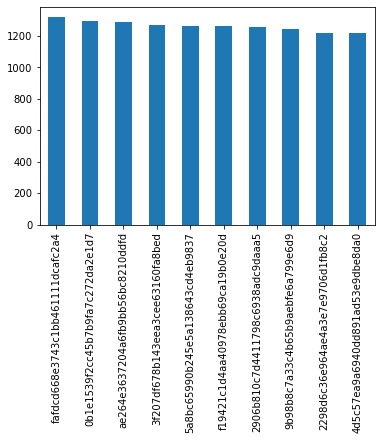

In [37]:
# Look at the distribution of offer_id
transcript_df[(transcript_df['time']==0)
              &(transcript_df['event']=='offer received')]['offer_id'].value_counts().plot.bar()
print('Total offer_id count:',len(transcript_df[(transcript_df['time']==0)
                                                &(transcript_df['event']=='offer received')]['offer_id']))
print('mean:',transcript_df[(transcript_df['time']==0)
              &(transcript_df['event']=='offer received')]['offer_id'].value_counts().mean())
# Pretty uniformly distributed initial offer_id at time equals zero across the customers base

In [38]:
# Let's split off one of the customer segments where the 0 time is a specific offer
offer_selected = '3f207df678b143eea3cee63160fa8bed'
offer1_customers = transcript_df[(transcript_df['time']== 0)
              &(transcript_df['event']== 'offer received')
              &(transcript_df['offer_id']== offer_selected)
             ]['person'].unique()
offer1_df = transcript_df[transcript_df['person'].isin(offer1_customers)]

In [39]:
# Do all of the customers that received this offer as their first offer receive the same subsequent offers?
offer1_df[offer1_df['person'] == offer1_customers[0]]

,person,offer_id,event,amount,reward_rcvd,time,first_time
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,offer received,0.00,0.0,0,0.0
53182,2eeac8d8feae4a8cad5a6af0499a211d,2298d6c36e964ae4a3e7e9706d1fb8c2,offer received,0.00,0.0,168,0.0
65844,2eeac8d8feae4a8cad5a6af0499a211d,2298d6c36e964ae4a3e7e9706d1fb8c2,offer viewed,0.00,0.0,168,0.0
85293,2eeac8d8feae4a8cad5a6af0499a211d,0,transaction,2.32,0.0,216,0.0
110835,2eeac8d8feae4a8cad5a6af0499a211d,fafdcd668e3743c1bb461111dcafc2a4,offer received,0.00,0.0,336,0.0
130152,2eeac8d8feae4a8cad5a6af0499a211d,fafdcd668e3743c1bb461111dcafc2a4,offer viewed,0.00,0.0,348,0.0
141567,2eeac8d8feae4a8cad5a6af0499a211d,0,transaction,5.29,0.0,378,0.0
187136,2eeac8d8feae4a8cad5a6af0499a211d,0,transaction,7.14,0.0,456,0.0
187137,2eeac8d8feae4a8cad5a6af0499a211d,fafdcd668e3743c1bb461111dcafc2a4,offer completed,0.00,2.0,456,0.0
243231,2eeac8d8feae4a8cad5a6af0499a211d,0,transaction,0.87,0.0,570,0.0


In [51]:
len(transcript_df['person'].unique())

17000

Values of total offers received: [0 1 2 3 4 5 6]
Mean value 4.744982104697353
Offers received: 76277
Unique customers that received offers: 16994
Customers that did not receive an offer: 
 ['eb540099db834cf59001f83a4561aef3' '12ede229379747bd8d74ccdc20097ca3'
 'c6e579c6821c41d1a7a6a9cf936e91bb' 'ae8111e7e8cd4b60a8d35c42c1110555'
 '3a4874d8f0ef42b9a1b72294902afea9' 'da7a7c0dcfcb41a8acc7864a53cf60fb']


<AxesSubplot:>

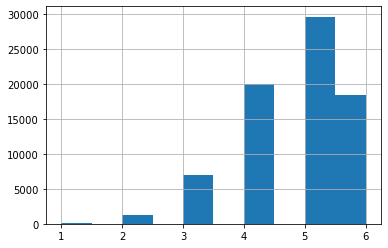

In [59]:
# Are the amounts of offers the same across all customers?
transcript_df['offer_rcvd_count'] = 0
transcript_df['offer_rcvd_count'].loc[(transcript_df['event']=='offer received')] = transcript_df[(transcript_df['event']=='offer received')].groupby('person')['person'].transform('count')
print('Values of total offers received:',np.sort(transcript_df['offer_rcvd_count'].unique()))
print('Mean value', transcript_df[transcript_df['offer_rcvd_count']>0]['offer_rcvd_count'].mean())
print('Offers received:',len(transcript_df[transcript_df['offer_rcvd_count']>0]['offer_rcvd_count']))
print('Unique customers that received offers:',len(transcript_df[transcript_df['offer_rcvd_count']>0]['person'].unique()))
no_offers_list = transcript_df[~transcript_df['person'].isin(transcript_df[transcript_df['offer_rcvd_count']>0]['person'].unique())]['person'].unique()
print('Customers that did not receive an offer: \n',no_offers_list)
transcript_df[transcript_df['offer_rcvd_count']>0]['offer_rcvd_count'].hist()

## Customers with no offers received

In [66]:
transcript_df[transcript_df['person'].isin(no_offers_list)].sort_values(by = ['person','time'])

,person,offer_id,event,amount,reward_rcvd,time,first_time,offer_rcvd_count
22092,12ede229379747bd8d74ccdc20097ca3,0,transaction,16.62,0.0,18,18.0,0
109815,12ede229379747bd8d74ccdc20097ca3,0,transaction,27.60,0.0,324,18.0,0
292962,12ede229379747bd8d74ccdc20097ca3,0,transaction,19.03,0.0,654,18.0,0
109340,3a4874d8f0ef42b9a1b72294902afea9,0,transaction,22.75,0.0,324,324.0,0
142347,3a4874d8f0ef42b9a1b72294902afea9,0,transaction,27.20,0.0,378,324.0,0
259644,3a4874d8f0ef42b9a1b72294902afea9,0,transaction,17.67,0.0,576,324.0,0
106812,ae8111e7e8cd4b60a8d35c42c1110555,0,transaction,17.51,0.0,306,306.0,0
110707,ae8111e7e8cd4b60a8d35c42c1110555,0,transaction,28.70,0.0,330,306.0,0
184609,ae8111e7e8cd4b60a8d35c42c1110555,0,transaction,11.53,0.0,444,306.0,0
287598,ae8111e7e8cd4b60a8d35c42c1110555,0,transaction,9.72,0.0,636,306.0,0


Take a look at the customers that didn't receive any offers (6) <br> *Found that they each had transactions only. <br> Interesting that they didn't receive or view any offers despite having a customer profile.* <br> **Idea: use these customers as a baseline for time between transactions without offer influence (A/B test).** 
<br> - I don't know how these customers provide a useful baseline set. 

In [69]:
profile_df[profile_df['id'].isin(no_offers_list)]

,id,member_date,member_year,member_month,gender,age,income,known_prof
872,c6e579c6821c41d1a7a6a9cf936e91bb,2017-10-14,2017,10,F,72,35000.0,True
5425,da7a7c0dcfcb41a8acc7864a53cf60fb,2017-08-01,2017,8,NaN,118,NaN,False
5639,eb540099db834cf59001f83a4561aef3,2017-09-29,2017,9,F,66,34000.0,True
6789,3a4874d8f0ef42b9a1b72294902afea9,2016-08-16,2016,8,F,55,88000.0,True
14763,ae8111e7e8cd4b60a8d35c42c1110555,2017-01-06,2017,1,F,54,72000.0,True
15391,12ede229379747bd8d74ccdc20097ca3,2015-10-05,2015,10,M,91,70000.0,True


Pivot each offer_id as a seperate column...

In [ ]:
## This is where I left off
## Thinking of using the pivot table to create an abbreviated sequence array [0,1,0,0,1,1]
## Then use those to compare and identify the customer list of similar sequences
## Be sure to note the order or create a dictionary (probably best idea) so values can be linked back to offer frame

In [68]:
transcript_df[transcript_df['event']=='offer received'].pivot_table(index='person', columns='offer_id', values = 'time').reset_index()

offer_id,person,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
0,0009655768c64bdeb2e877511632db8f,NaN,NaN,576.0,336.0,NaN,168.0,NaN,NaN,408.0,504.0
1,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,372.0,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,408.0,168.0,NaN,0.0,NaN,336.0,504.0,NaN,NaN,NaN
3,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,408.0,504.0,NaN,168.0,NaN,168.0
4,0020ccbbb6d84e358d3414a3ff76cffd,NaN,168.0,NaN,NaN,NaN,408.0,504.0,NaN,336.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16989,fff3ba4757bd42088c044ca26d73817a,NaN,NaN,492.0,NaN,NaN,420.0,168.0,NaN,NaN,0.0
16990,fff7576017104bcc8677a8d63322b5e1,NaN,NaN,NaN,NaN,168.0,NaN,576.0,408.0,NaN,252.0
16991,fff8957ea8b240a6b5e634b6ee8eafcf,NaN,NaN,NaN,504.0,576.0,NaN,NaN,NaN,NaN,408.0
16992,fffad4f4828548d1b5583907f2e9906b,NaN,NaN,NaN,NaN,NaN,168.0,576.0,NaN,204.0,NaN


In [ ]:
# left off here, was trying to use pivot to get each offer with the time for each row being a customer

In [ ]:
rcv_seq = pd.DataFrame(columns = {'person','offer_1','offer_2','offer_3','offer_4','offer_5','offer_6'})
for x in transcript_df['person'].unique()[[0]]:
    df_rcv_seq = transcript_df[(transcript_df['person'] == x) # filter down transactions by customer
                                &(transcript_df['event']=='offer received')] # filter to only offers received
    
    rcv_seq = rcv_seq.append([df_rcv_seq.])
#     if df_rcv_seq.time.min()>0:
#         rcv_seq.append([x,df_1.time.min()])

In [ ]:
transcript_df[transcript_df['event']=='offer received']['offer_rcvd_count']

![ChessUrl](https://upload.wikimedia.org/wikipedia/commons/7/71/ChessPawnSpecialMoves.gif "chess")

## Finding
- It appears that there is a specific pattern of the data for customers with a non-zero start time.
- These customers might be the test set or part of an A/B test. 
- The data appears to have a 75/25 split of customers with data since time zero and those with later start times. 
- **Possible Hypothesis** is a question of importance might be: how to backfill a likely previous unknown history to complete a customer profile?
- **Action** lets focus on the transactions with complete start times.

## Forecast Spending
- If spending can be forecasted for a given customer and the probability of offer completion, the next step would be linking known spending in a time period to a given offer that capitalizes providing customer benefit when they need it and lowering the required offer amount since spending had a high probability of occuring. 

In [ ]:
# base customer data with complete known history from time = 0
customer_base_df = transcript_df[transcript_df['first_time']==0] 

In [ ]:
# unique customer 
customer = customer_base_df.person.unique()[1]

In [ ]:
customer_base_df[customer_base_df['person'] == customer]

In [ ]:
# Find the time between received and view (tbrv)
customer_list = customer_base_df.person.unique()[0:3]
offer_view = copy.deepcopy(customer_base_df)
offer_view['tbrv'] = -1

for customer in customer_list:
    offer_view1 = offer_view[offer_view['person'] == customer]
    # Create metrics or counts of transaction data at this point for the customer
    # However, it will cause duplicate values across the transactions
    offer_view1 = offer_view1[(offer_view1['event']=='offer received')|(offer_view1['event']=='offer viewed')]
    offer_view1_len = len(offer_view1.index)
    # ^This filters the transaction data to offer received and viewed records by customer
    
    for x in range(offer_view1_len): 
        if (offer_view1['event'].loc[offer_view1.index[x]] == 'offer received'):
            temp_offer = offer_view1['offer_id'].loc[offer_view1.index[x]]
            temp_offer_index = offer_view1.index[x]
            temp_view = offer_view1[offer_view1['offer_id'] == temp_offer]
            temp_view_index = temp_view.index
            
            if (offer_view1['event'].loc[offer_view1.index[x+1]]=='offer viewed'):   
                print(offer_view1.time.loc[offer_view1.index[x+1]]-offer_view1.time.loc[offer_view1.index[x]])
                offer_view['tbrv'].loc[offer_view1.index[x]] = (offer_view1.time.loc[offer_view1.index[x+1]]-offer_view1.time.loc[offer_view1.index[x]])

In [ ]:
temp_view

In [ ]:
offer_view[offer_view['tbrv']>-1]

In [ ]:
offer_view1[offer_view1.index == 110829]

In [ ]:
transcript_df[transcript_df['person'] == '62b12261e5a34e81ba0a6259b5d6ba90']

In [ ]:
# first customer with a member date - transaction record
transcript_df[transcript_df['person'] == '77388a70eaf14433b4efc5d01fa947bf']
# interesting to note is that it does not seem as if the transaction date goes to the maximum time in the data

In [ ]:
# this looks at someone that has a transaction at the max time in the dataset.
transcript_df[transcript_df['person'] == 'c02b10e8752c4d8e9b73f918558531f7']

**Time between receiving, viewing and completing the offer for each customer since time = 0.**

In [ ]:
for x in transcript_df['person'].unique()[0:3]:
    print(x)
    df_1 = transcript_df[transcript_df['person'] == x]

In [ ]:
for x in transcript_df['person'].unique()[0:3]:
    print(x)
    df_1 = transcript_df[transcript_df['person'] == x]
    df_1 = df_1[(df_1['event']=='transaction')|(df_1['event']=='offer completed')]
    for i in df_1['time'].unique():
        df_2 = df_1[df_1['time']==i]
        if len(df_2)>1:
            v = df_2[df_2['event']=='transaction']['amount'].values[0]
            print(v)
            df_2['amount'] = df_2['amount'].fillna(v)
            print(df_2)
#             
        

In [ ]:
df_1

In [ ]:
transcript_df['person'].unique()[2]

In [ ]:
transcript_df[transcript_df['person'] == 'e2127556f4f64592b11af22de27a7932']

In [ ]:
x_df = transcript_df[transcript_df['person'] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

In [ ]:
for x in x_df: 
    if x_df['time'].count()>1:
        if 

In [ ]:
transcript_df.iloc[12658]

In [ ]:
transcript_df['value'][1].keys()
transcript_df['value'][1].values()

In [ ]:
x = eval(transcript_df.value[1])
x['offer id']

In [ ]:
df_test = pd.json_normalize(transcript_df['value'].to_dict())

In [ ]:
transcript_df.event.unique()

In [ ]:
transcript_df[transcript_df['event']=='offer received'].value.unique()

In [ ]:
transcript_df[transcript_df['event']=='offer viewed'].value.unique()

In [ ]:
transcript_df[transcript_df['event']=='offer completed'].value.unique()

In [ ]:
transcript_df[transcript_df['event']=='transaction'].value.unique()